In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path

import matplotlib.pyplot as plt
import json, pdb

from ignite.engine import Events
from ignite.engine import create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import CategoricalAccuracy, Recall, Precision
from ignite.metrics import Loss

# Load Data

In [3]:
PATH = Path('data')
train_df = pd.read_csv(PATH/'train.csv')
train_df.head(3)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5


In [4]:
submit_df = pd.read_csv(PATH/'sample_submission.csv')
submit_df.head(3)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0


In [5]:
img_fns = list(os.listdir(PATH/'train'))
img_fns[:3]

['e471c4f6-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png',
 'bb15f496-bba8-11e8-b2ba-ac1f6b6435d0_green.png',
 'e7fa747a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png']

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None, color="teal"):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

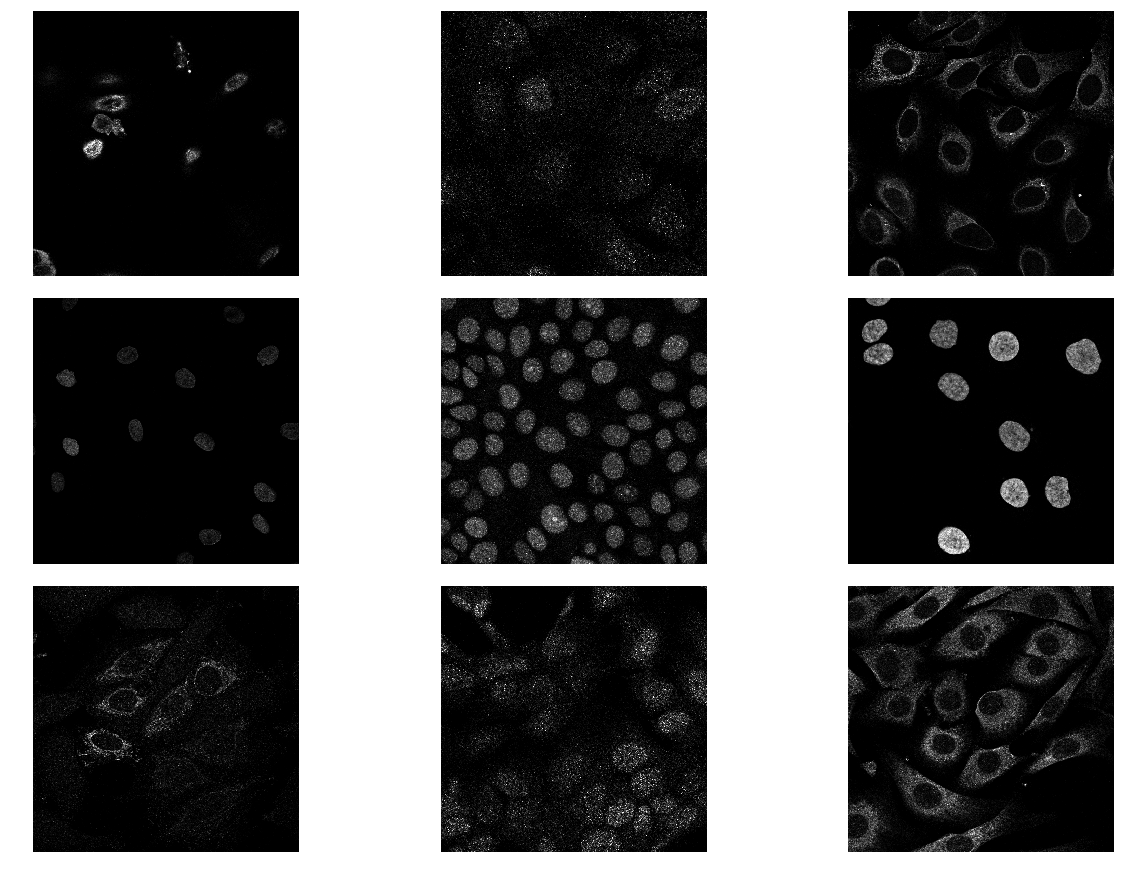

In [7]:
imgs = [Image.open(PATH/'train'/f'{o}') for o in img_fns[:9]]

fig, axes = plt.subplots(3,3, figsize=(18,12))
for i,ax in enumerate(axes.flat):
    show_img(imgs[i], ax=ax)
plt.tight_layout(pad=0.1)

In [8]:
plt.close('all')

# Split Train - Test Set

In [9]:
from sklearn.model_selection import train_test_split

trn_ids = [o for o in train_df.Id]
trn_targs = [o for o in train_df.Target]

train, val = train_test_split(train_df, test_size=0.2)

In [10]:
len(train), len(val)

(24857, 6215)

In [11]:
trn_x = list(train['Id'])
trn_y = list(train['Target'])

In [12]:
val_x = list(val['Id'])
val_y = list(val['Target'])

# Dataset

## Definitions

In [13]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from sklearn.preprocessing import MultiLabelBinarizer

In [14]:
LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

In [15]:
class MultiBandMultiLabelDataset(Dataset):
    BANDS_NAMES = ['_red.png','_green.png','_blue.png','_yellow.png']
    
    def __len__(self):
        return len(self.images_df)
    
    def __init__(self, images_df, 
                 base_path, 
                 image_transform, 
                 augmentator=None,
                 train_mode=True    
                ):
        if not isinstance(base_path, pathlib.Path):
            base_path = pathlib.Path(base_path)
            
        self.images_df = images_df.copy()
        self.image_transform = image_transform
        self.augmentator = augmentator
        self.images_df.Id = self.images_df.Id.apply(lambda x: base_path / x)
        self.mlb = MultiLabelBinarizer(classes=list(LABEL_MAP.keys()))
        self.train_mode = train_mode

                                      
        
    def __getitem__(self, index):
        y = None
        X = self._load_multiband_image(index)
        if self.train_mode:
            y = self._load_multilabel_target(index)
        
        # augmentator can be for instance imgaug augmentation object
        if self.augmentator is not None:
            X = self.augmentator(X)
            
        X = self.image_transform(X)
            
        return X, y 
        
    def _load_multiband_image(self, index):
        row = self.images_df.iloc[index]
        image_bands = []
        for band_name in self.BANDS_NAMES:
            p = str(row.Id.absolute()) + band_name
            pil_channel = Image.open(p)
            image_bands.append(pil_channel)
            
        # lets pretend its a RBGA image to support 4 channels
        band4image = Image.merge('RGBA', bands=image_bands)
        return band4image
    
    
    def _load_multilabel_target(self, index):
        return list(map(int, self.images_df.iloc[index].Target.split(' ')))
    
        
    def collate_func(self, batch):
        labels = None
        images = [x[0] for x in batch]
        
        if self.train_mode:
            labels = [x[1] for x in batch]
            labels_one_hot  = self.mlb.fit_transform(labels)
            labels = torch.FloatTensor(labels_one_hot)
            
        
        return torch.stack(images)[:,:4,:,:], labels

## Archive

In [16]:
# class CustomDataset(Dataset):
#     def __init__(self, x, y):
#         super().__init__()
#         self.x = x
#         self.y = y
#         self.mlb = MultiLabelBinarizer(classes=list(LABEL_MAP.keys()))
#         self.band_names = ['_red.png','_green.png','_blue.png','_yellow.png']
#         self.image_transform = transforms.Compose([
#             transforms.ToTensor()])
    
#     def __len__(self):
#         return len(self.x)
    
#     def __getitem__(self, i):
#         img = self.load_img_array(self.x[i])
#         img = self.image_transform(img)
        
#         y = self.load_ohe(self.y[i])
# #         y = y.astype(float)
#         return img, torch.FloatTensor(y)
        
#     def load_img_array(self, img_id):
#         image_bands = []
        
#         for band_name in self.band_names:
#             p = f'data/train/{img_id + band_name}'            
#             pil_channel = Image.open(p)
#             image_bands.append(pil_channel)
        
#         band4image = Image.merge('RGBA', bands=image_bands)
#         return band4image
        
#     def load_ohe(self, label_list):
#         label_list = label_list.split(' ')
#         return self.mlb.fit_transform([[int(o) for o in label_list]])

## Instances

In [17]:
import pathlib

In [18]:
PATH_TO_IMAGES = 'data/train/'
PATH_TO_TEST_IMAGES = 'data/test/'
PATH_TO_META = 'data/train.csv'
SAMPLE_SUBMIT = 'data/sample_submission.csv'

In [19]:
train_df = pd.read_csv(PATH/'train.csv')
df_train, df_test  = train_test_split(train_df, test_size=0.2, random_state=33)
submit_df = pd.read_csv(PATH/'sample_submission.csv')

In [20]:
image_transform = transforms.Compose([
            transforms.Resize(512),
            transforms.ToTensor(),])

In [21]:
train_set = MultiBandMultiLabelDataset(df_train, base_path=PATH_TO_IMAGES, image_transform=image_transform)
val_set = MultiBandMultiLabelDataset(df_test, base_path=PATH_TO_IMAGES, image_transform=image_transform)
submit_set = MultiBandMultiLabelDataset(submit_df, base_path=PATH_TO_TEST_IMAGES, train_mode=False, image_transform=image_transform)

train_load = DataLoader(train_set, collate_fn=train_set.collate_func, batch_size=16, num_workers=6)
test_load = DataLoader(val_set, collate_fn=val_set.collate_func, batch_size=16, num_workers=6)
submission_load = DataLoader(submit_set, collate_fn=submit_set.collate_func, batch_size=16, num_workers=6)

# Model Definition

In [22]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import resnet50
from torch.autograd import Variable
from torch import optim, save

## Model Functions

In [23]:
def get_model(n_classes, image_channels=4):
    model = resnet50(pretrained=True)
    for p in model.parameters():
        p.requires_grad = True
    inft = model.fc.in_features
    model.fc = nn.Linear(in_features=inft, out_features=n_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
    return model 

In [24]:
def train(trainer, train_loader, test_loader, checkpoint_path='py_best_models/bestmodel_{}_{}.torch', epochs=1):
    @trainer.on(Events.ITERATION_COMPLETED)
    def log_training_loss(engine):
        iter = (engine.state.iteration - 1) % len(train_loader) + 1
        if iter % 100 == 0:
            print("Epoch[{}] Iteration[{}/{}] Loss: {:.2f}"
                  "".format(engine.state.epoch, iter, len(train_loader), engine.state.output))

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(engine):
        evaluator.run(test_loader)
        metrics = evaluator.state.metrics
        avg_nll = metrics['loss']
        print("Training Results - Epoch: {}  Avg loss: {:.2f}"
              .format(engine.state.epoch, avg_nll))
        evaluate(model, test_loader, threshold=0.2)
        save(model, checkpoint_path.format(engine.state.epoch, avg_nll))
    trainer.run(train_loader, max_epochs=epochs)
    
    return model 

def evaluate(model, test_loader, threshold=0.2):
    all_preds = []
    true = []
    model.eval()
    for b in test_loader:
        X, y = b
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        pred = model(X)
        all_preds.append(pred.sigmoid().cpu().data.numpy())
        true.append(y.cpu().data.numpy())
        
        
    P = np.concatenate(all_preds)
    R = np.concatenate(true)
    
    f1 = f1_score(P>threshold, R, average='macro')
    print('Val F1 Score:')
    print(f1)
    return f1

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Test Model

In [26]:
model = get_model(28,4)
device='cuda:0'
criterion = nn.BCEWithLogitsLoss()

if torch.cuda.is_available():
    criterion = criterion.cuda()
    
evaluator = create_supervised_evaluator(model, device=device,
                                        metrics={'loss': Loss(criterion)})

optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()), 
                       lr=0.00005)

trainer = create_supervised_trainer(model, 
                                    optimizer, 
                                    criterion, 
                                    device=device)

In [76]:
model = train(trainer, train_load, test_load, epochs=2)

Epoch[1] Iteration[100/1554] Loss: 0.17
Epoch[1] Iteration[200/1554] Loss: 0.18
Epoch[1] Iteration[300/1554] Loss: 0.15
Epoch[1] Iteration[400/1554] Loss: 0.24
Epoch[1] Iteration[500/1554] Loss: 0.16
Epoch[1] Iteration[600/1554] Loss: 0.16
Epoch[1] Iteration[700/1554] Loss: 0.16
Epoch[1] Iteration[800/1554] Loss: 0.15
Epoch[1] Iteration[900/1554] Loss: 0.18
Epoch[1] Iteration[1000/1554] Loss: 0.16
Epoch[1] Iteration[1100/1554] Loss: 0.16
Epoch[1] Iteration[1200/1554] Loss: 0.16
Epoch[1] Iteration[1300/1554] Loss: 0.14
Epoch[1] Iteration[1400/1554] Loss: 0.15
Epoch[1] Iteration[1500/1554] Loss: 0.19
Training Results - Epoch: 1  Avg loss: 0.16
Val F1 Score:
0.085891768506236


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch[2] Iteration[100/1554] Loss: 0.15
Epoch[2] Iteration[200/1554] Loss: 0.17
Epoch[2] Iteration[300/1554] Loss: 0.15
Epoch[2] Iteration[400/1554] Loss: 0.23
Epoch[2] Iteration[500/1554] Loss: 0.16
Epoch[2] Iteration[600/1554] Loss: 0.14
Epoch[2] Iteration[700/1554] Loss: 0.15
Epoch[2] Iteration[800/1554] Loss: 0.14
Epoch[2] Iteration[900/1554] Loss: 0.17
Epoch[2] Iteration[1000/1554] Loss: 0.16
Epoch[2] Iteration[1100/1554] Loss: 0.15
Epoch[2] Iteration[1200/1554] Loss: 0.16
Epoch[2] Iteration[1300/1554] Loss: 0.14
Epoch[2] Iteration[1400/1554] Loss: 0.14
Epoch[2] Iteration[1500/1554] Loss: 0.18
Training Results - Epoch: 2  Avg loss: 0.16
Val F1 Score:
0.09773222651680026


In [61]:
# model = torch.load('bestmodel_71_0.41488165186953374.torch')

In [62]:
from sklearn.metrics import f1_score
res = evaluate(model, test_load, threshold=0.2)

0.24648810582517108


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Create submission

In [63]:
def predict_submission(model, submission_load):
    all_preds = []
    model.eval()
    for i, b in enumerate(submission_load):
        if i % 100: print('processing batch {}/{}'.format(i, len(submission_load)))
        X, _ = b
        if torch.cuda.is_available():
            X = X.cuda()
        pred = model(X)
        all_preds.append(pred.sigmoid().cpu().data.numpy())
    return np.concatenate(all_preds)
        
         
def make_submission_file(sample_submission_df, predictions):
    submissions = []
    for row in predictions:
        subrow = ' '.join(list([str(i) for i in np.nonzero(row)[0]]))
        submissions.append(subrow)
    
    sample_submission_df['Predicted'] = submissions
    sample_submission_df.to_csv('submission_pytorch.csv', index=None)
    
    return sample_submission_df

In [64]:
submission_predictions = predict_submission(model, submission_load)

processing batch 1/732
processing batch 2/732
processing batch 3/732
processing batch 4/732
processing batch 5/732
processing batch 6/732
processing batch 7/732
processing batch 8/732
processing batch 9/732
processing batch 10/732
processing batch 11/732
processing batch 12/732
processing batch 13/732
processing batch 14/732
processing batch 15/732
processing batch 16/732
processing batch 17/732
processing batch 18/732
processing batch 19/732
processing batch 20/732
processing batch 21/732
processing batch 22/732
processing batch 23/732
processing batch 24/732
processing batch 25/732
processing batch 26/732
processing batch 27/732
processing batch 28/732
processing batch 29/732
processing batch 30/732
processing batch 31/732
processing batch 32/732
processing batch 33/732
processing batch 34/732
processing batch 35/732
processing batch 36/732
processing batch 37/732
processing batch 38/732
processing batch 39/732
processing batch 40/732
processing batch 41/732
processing batch 42/732
p

processing batch 338/732
processing batch 339/732
processing batch 340/732
processing batch 341/732
processing batch 342/732
processing batch 343/732
processing batch 344/732
processing batch 345/732
processing batch 346/732
processing batch 347/732
processing batch 348/732
processing batch 349/732
processing batch 350/732
processing batch 351/732
processing batch 352/732
processing batch 353/732
processing batch 354/732
processing batch 355/732
processing batch 356/732
processing batch 357/732
processing batch 358/732
processing batch 359/732
processing batch 360/732
processing batch 361/732
processing batch 362/732
processing batch 363/732
processing batch 364/732
processing batch 365/732
processing batch 366/732
processing batch 367/732
processing batch 368/732
processing batch 369/732
processing batch 370/732
processing batch 371/732
processing batch 372/732
processing batch 373/732
processing batch 374/732
processing batch 375/732
processing batch 376/732
processing batch 377/732


processing batch 671/732
processing batch 672/732
processing batch 673/732
processing batch 674/732
processing batch 675/732
processing batch 676/732
processing batch 677/732
processing batch 678/732
processing batch 679/732
processing batch 680/732
processing batch 681/732
processing batch 682/732
processing batch 683/732
processing batch 684/732
processing batch 685/732
processing batch 686/732
processing batch 687/732
processing batch 688/732
processing batch 689/732
processing batch 690/732
processing batch 691/732
processing batch 692/732
processing batch 693/732
processing batch 694/732
processing batch 695/732
processing batch 696/732
processing batch 697/732
processing batch 698/732
processing batch 699/732
processing batch 701/732
processing batch 702/732
processing batch 703/732
processing batch 704/732
processing batch 705/732
processing batch 706/732
processing batch 707/732
processing batch 708/732
processing batch 709/732
processing batch 710/732
processing batch 711/732


In [65]:
THRESHOLD = 0.2
p = submission_predictions>THRESHOLD

submission_file = make_submission_file(sample_submission_df=submit_df,
                     predictions=p)

In [66]:
submission_file.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 7 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,2 21 25


# FastAi Detour